In [1]:
import re
import time
import pandas as pd
import json
import requests
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from bs4 import BeautifulSoup
from tqdm import tqdm
from datetime import datetime

In [2]:
#data 불러오기
stock = pd.read_csv('./recommend_stock.csv')

In [3]:
#date 타입 날짜 문자로 바꾸기
stock['end_date'] = stock.date.apply(lambda x : re.sub("-","",x))
stock['end_date']= stock['end_date'].astype('str')

#date date타입으로 변환
stock['date'] = pd.to_datetime(stock['date'])

In [4]:
stock

,date,stock_name,stock_code,end_date
0,2019-10-29,알리코제약,260660,20191029
1,2019-10-29,KPX생명과학,114450,20191029
2,2019-10-29,제일바이오,052670,20191029
3,2019-10-30,아스타,246720,20191030
4,2019-10-30,SM,063440,20191030
...,...,...,...,...
977,2023-02-01,오픈베이스,049480,20230201
978,2023-02-01,일성건설,013360,20230201
979,2023-02-02,선익시스템,171090,20230202
980,2023-02-02,누리플렉스,040160,20230202


In [5]:
#한국투자 API 보안 인증키 발급 
APP_KEY = "PSDbkNNrIX3j60cW2MEFnBGZDZ1BzpgDxvC0"
APP_SECRET = "QfaZRX24K15ojO4yjG5o5dM+SUvJT4PYiK+tKKzgikyhmfrnTXoxOwn9rCf2hzXdtOhh4v3/O4bSFfQgS+u6ojdb6KgWuyub4GRraoWYaJTJyHSRqWUPab2GiCvrI/aIjx5S925MohrETq0k/eopFHgMInG0lmZdAh5TaegaZ1NDpNvPW8Y="
URL_BASE = "https://openapi.koreainvestment.com:9443"
PATH = "oauth2/tokenP"
URL = f"{URL_BASE}/{PATH}"

headers = {"content-type":"application/json"}
body = {"grant_type":"client_credentials",
        "appkey":APP_KEY, 
        "appsecret":APP_SECRET}

res = requests.post(URL, headers=headers, data=json.dumps(body))
ACCESS_TOKEN = res.json()["access_token"]

In [6]:
#일자별 시세 가져오기 (함수)
def get_info_from_kisapi(stock_code,end_date):
    time.sleep(0.1)
    
    st_date = pd.date_range(end = end_date,periods=20)[0]
    st_date = st_date.strftime("%Y%m%d")
    
    URL = 'https://openapi.koreainvestment.com:9443/uapi/domestic-stock/v1/quotations/inquire-daily-itemchartprice'

    headers = {"Content-Type":"application/json", 
            "authorization": f"Bearer {ACCESS_TOKEN}",
            "appKey":APP_KEY,
            "appSecret":APP_SECRET,
            "tr_id":"FHKST03010100"
            }

    params = {
        "FID_COND_MRKT_DIV_CODE":"J",
        "FID_INPUT_ISCD":stock_code,
        "FID_INPUT_DATE_1" : st_date,
        "FID_INPUT_DATE_2" : end_date,
        "FID_PERIOD_DIV_CODE" : "D",
        "FID_ORG_ADJ_PRC" : "1"
    }

    res = requests.get(URL, headers=headers, params=params)   
    res = res.json().get('output2')[0:11]
    res.reverse()
    return res

In [68]:
#종목 일자별 데이터 가져오기 (함수)
def get_info_from_stock(res):
    temp = pd.DataFrame()
    day = 10
    for i in res:

        data = pd.DataFrame({
            'stck_oprc' :  i.get('stck_oprc'),
            'stck_clpr' : i.get('stck_clpr'),
            'stck_hgpr' : i.get('stck_hgpr'),
            'stck_lwpr' : i.get('stck_lwpr'),
            'acml_vol'  : i.get('acml_vol')},
            index=[f'D{day}']
        )
        temp = pd.concat([temp,data])
        day -=1
    temp= temp.transpose()
    
    br_pr = temp.iloc[1:2,9:10].reset_index(drop = True)
    br_pr.columns = 'br_pr_'+ br_pr.columns
    #당일시가
    tr_pr = temp.iloc[0:1,10:].reset_index(drop = True)    
    tr_pr.columns = 'tr_pr_'+ tr_pr.columns
    #당일고가
    tr_hpr = temp.iloc[2:3,10:].reset_index(drop = True)
    tr_hpr.columns = 'tr_hpr_'+ tr_hpr.columns
    #거래량(10일)
    br_vol = temp.iloc[4:5,0:10].reset_index(drop = True)
    br_vol.columns = 'Volume_'+ br_vol.columns
    #당일거래량
    tr_vol = temp.iloc[4:5,10:].reset_index(drop = True)
    tr_vol.columns = 'tr_vol_'+ tr_vol.columns
    #저점(10일)
    br_lpr = temp.iloc[3:4,0:10].reset_index(drop = True)
    br_lpr.columns = 'lpr_'+ br_lpr.columns
    #데이터 합치기 
    data = pd.concat([br_pr,tr_pr,tr_hpr,br_vol,tr_vol,br_lpr], axis=1)
    # #인덱스 삽입
    # date_data = pd.DataFrame({'date' : end_date,
    #                         'stock_code' : stock_code}
    #                         ,index=[0])
    # data = pd.concat([date_data,data], axis =1 )
    
    return data   

In [76]:
#전종목 가져오기
data = pd.DataFrame()
for i in range(len(stock)):
    end_date = stock.end_date[i]
    stock_code = stock.stock_code[i]
    res = get_info_from_kisapi(stock_code,end_date)
    temp = get_info_from_stock(res)
    data = pd.concat([data,temp],axis=0)
# data = data.drop(columns=['date','stock_code'])
# data = data.reset_index().drop(columns = 'index')

In [77]:
#Nan 없애기
data = data.fillna(0)
data = data.reset_index().drop(columns = 'index')
stock2 = pd.concat([stock, data], axis=1)

In [78]:
#임시저장
data.to_csv('stock_data.csv', index=False, encoding='utf-8-sig')

In [80]:
#문자열숫자 숫자로 바꾸기 
for cn in stock2.columns[4:]:
    stock2[f'{cn}'] = stock2[f'{cn}'].apply(lambda x : int(x))

In [83]:
#임시저장
stock2.to_csv('stock2.csv', index=False, encoding='utf-8-sig')
stock2 = pd.read_csv('./stock2.csv')

In [84]:
#전일 종가 대비 당일 시가 증가율
stock2['gap_change'] = stock2.iloc[:,4:6].pct_change(axis =1).dropna(axis=1)

In [86]:
#전일(10일) 거래량 대비 당일 거래량 증가율 
stock2['mean_vlome'] = stock2.iloc[:,6:16].mean(axis =1)
stock2['today_vlome'] = stock2['tr_vol_D0']
stock2['vlome_change'] = stock2.iloc[:,29:].pct_change(axis=1)['today_vlome']

In [114]:
#저가 회귀식 기울기 구하기 
parameter = stock2.iloc[:,18:28]
parameter = parameter.T
for i in range(len(parameter.columns)):
    name = f'price{i}' 
    parameter = parameter.rename(columns={i:name})

parameter = parameter.reset_index().drop(columns=['index'])
parameter = parameter.reset_index()

data2=pd.DataFrame()
for i in range(0,982):
    model = sm.OLS.from_formula(f'index ~ price{i}', parameter).fit()
    slope = model.params[f'price{i}']
    temp = pd.DataFrame({'slope': slope} ,index =[i])
    data2 = pd.concat([data2,temp])

stock2['slope'] = data2

In [125]:
#당일 고가 대비 시가 차이
stock2['day_change'] = stock2['tr_hpr_D0'] - stock2['tr_pr_D0']
#당일 고가대비 시가 차이 (상승1 하락0)
stock2['deter_change'] = stock2.day_change.apply(lambda x : 1 if x > 0 else 0)

In [126]:
stock2.to_csv('stock2.csv', index=False, encoding='utf-8-sig')
stock2 = pd.read_csv('./stock2.csv')

In [127]:
stock_data = stock2.iloc[:,28:]
stock_data

,gap_change,mean_vlome,today_vlome,vlome_change,slope,day_change,deter_change
0,0.098361,759403.4,5115955,5.736808,-0.000826,1600,1
1,0.072674,2549913.9,7226351,1.833959,0.003547,1560,1
2,0.158549,2428170.9,25005590,9.298118,-0.010179,670,1
3,0.033505,30687.6,4124096,133.389656,0.002378,1970,1
4,0.128964,18347817.2,29449419,0.605064,0.006283,100,1
...,...,...,...,...,...,...,...
977,0.018634,3375239.5,6556918,0.942653,0.019043,170,1
978,0.022727,400864.9,3197820,6.977301,0.021181,180,1
979,0.050000,415594.3,1762833,3.241716,0.004736,900,1
980,0.044143,262144.3,3763972,13.358397,0.027751,500,1


In [24]:
# 당일거래량 주서오기
# stock3 = stock2.iloc[:,2:4]
# data2 = pd.DataFrame()
# for i in range(len(stock3)):
#     stock_code = stock3.stock_code[i]
#     end_date = stock3.end_date[i]
#     res = get_info_from_kisapi(stock_code,end_date)
#     acml_vol = res[-1].get('acml_vol')
#     temp = pd.DataFrame({'acml_vol' : acml_vol},index =[i])
#     data2 = pd.concat([data2,temp])
    

In [160]:
# 고가정보 주서오기
# data4 = pd.DataFrame()
# for i in range(len(stock3)):
#     stock_code = stock3.stock_code[i]
#     end_date = stock3.end_date[i]
#     res = get_info_from_kisapi(stock_code,end_date)
#     stck_hgpr = res[-1].get('stck_hgpr')
#     temp = pd.DataFrame({'stck_hgpr' : stck_hgpr},index =[i])
#     data4 = pd.concat([data4,temp])
# data4 = pd.concat([data4, stock2['tr_pr_D-0']], axis=1)
# data4['stck_hgpr'] = data4.stck_hgpr.apply(lambda x : int(x))

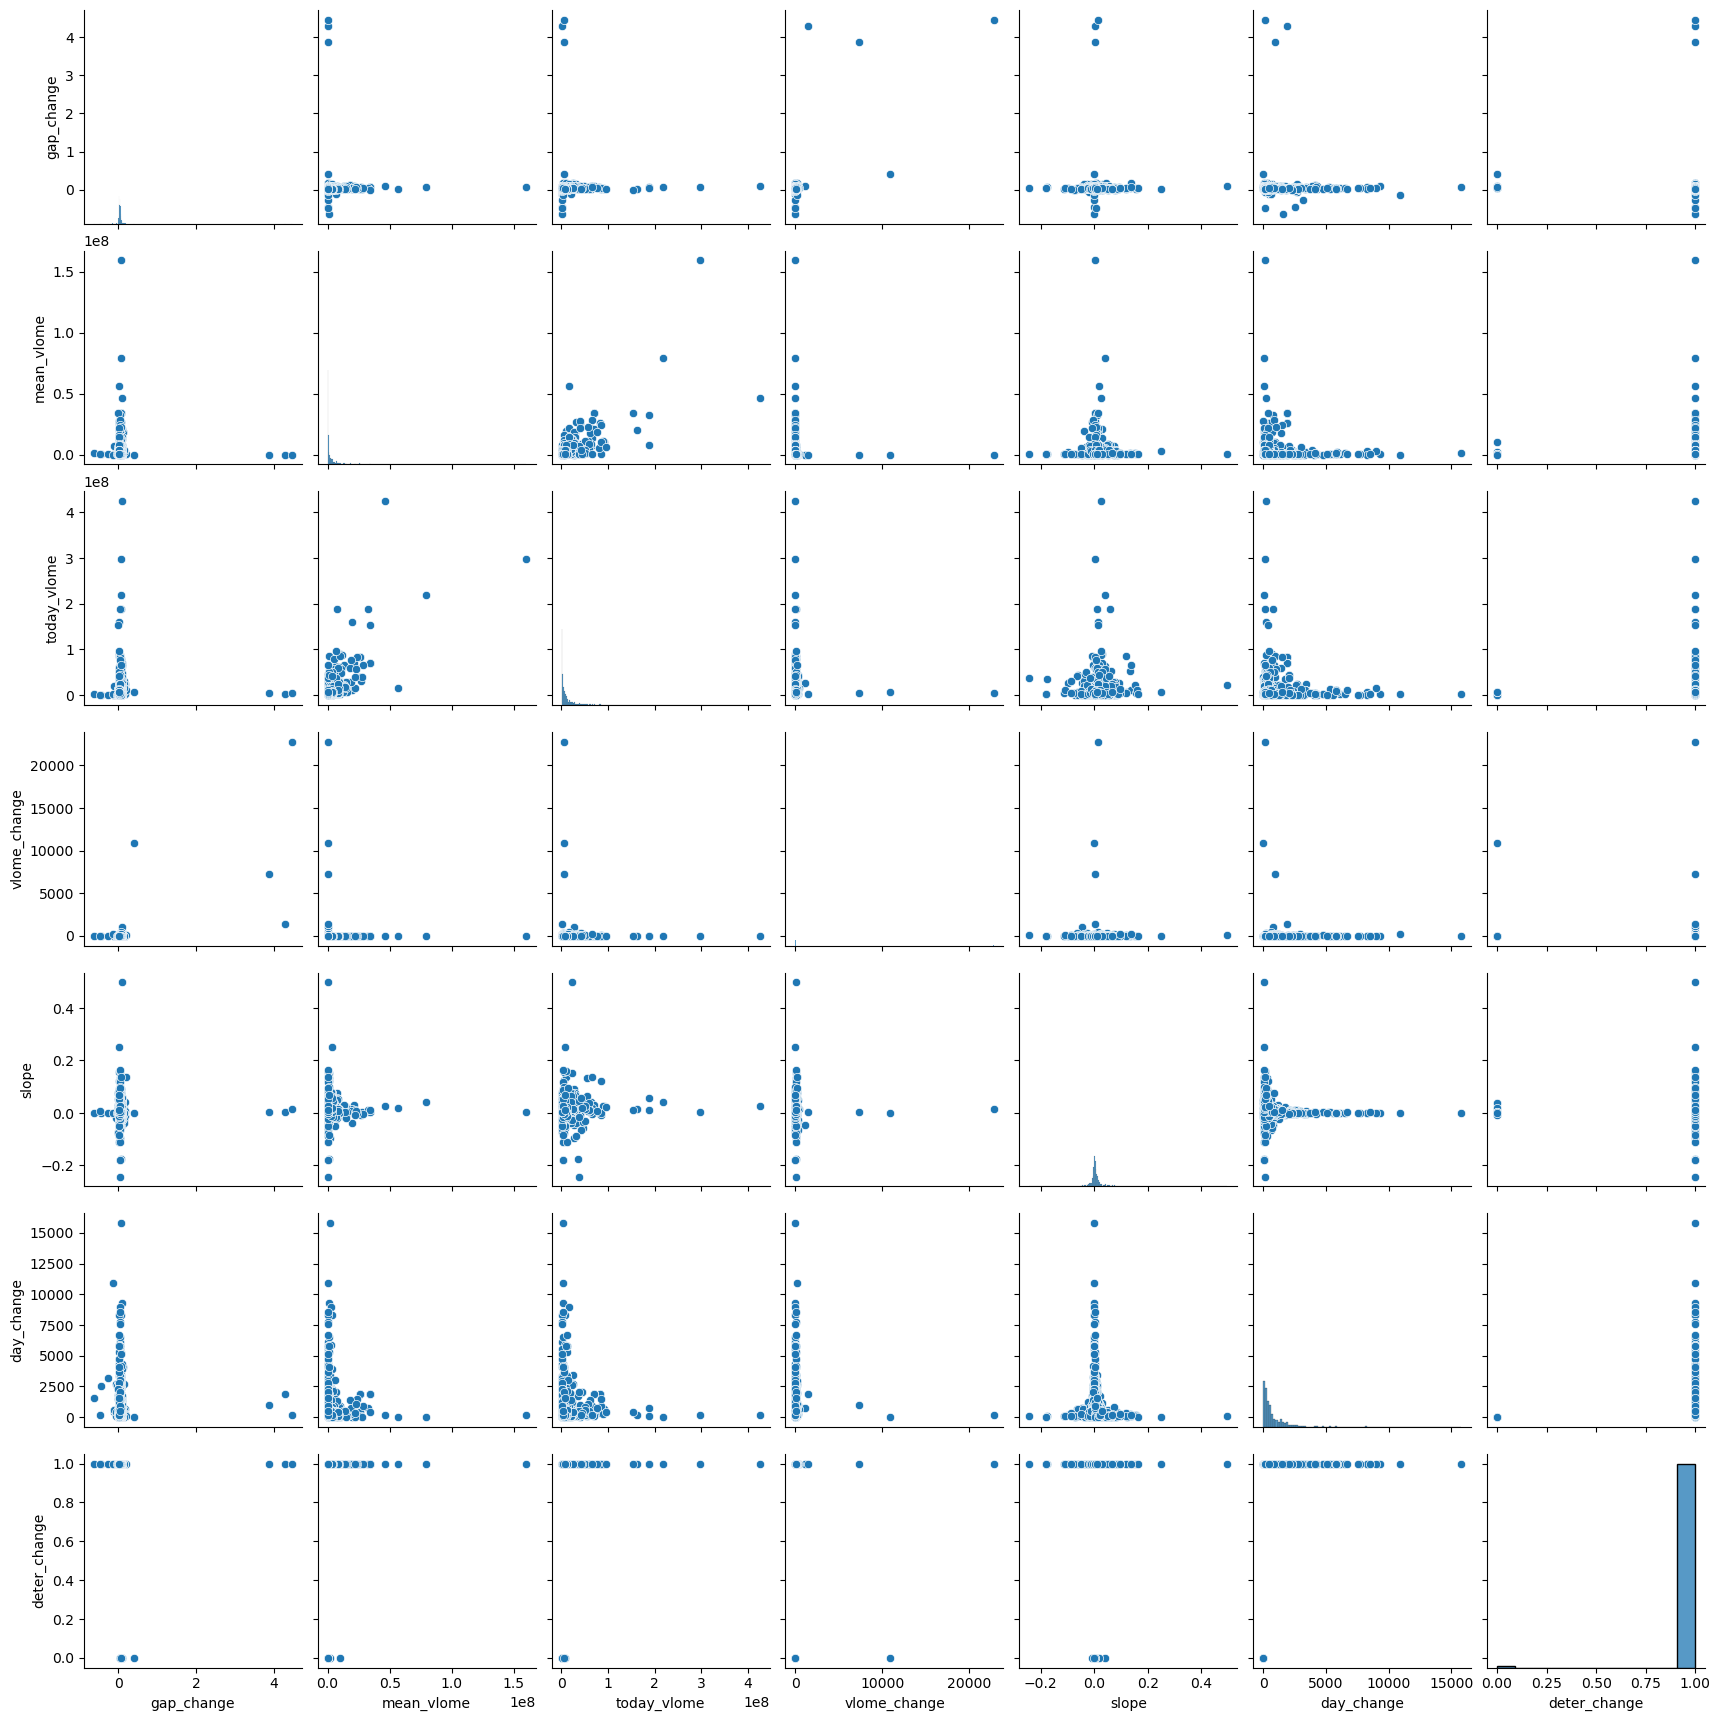

In [128]:
#산전도 그리기
%matplotlib inline
sns.pairplot(stock_data)

In [185]:
inf_index = stock_data.query('volume_change>100000').index
stock_data = stock_data.drop(index = inf_index)

In [148]:
stock_data.columns[0:5]

Index(['gap_change', 'mean_vlome', 'today_vlome', 'vlome_change', 'slope'], dtype='object')

In [149]:
Y = stock_data['deter_change']
X = stock_data[stock_data.columns[0:5]]

In [150]:
X = sm.add_constant(X)
model = sm.Logit(Y,X)
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.034743
         Iterations 13


In [151]:
print( results.summary())

                           Logit Regression Results                           
Dep. Variable:           deter_change   No. Observations:                  982
Model:                          Logit   Df Residuals:                      976
Method:                           MLE   Df Model:                            5
Date:                Mon, 20 Feb 2023   Pseudo R-squ.:                  0.1795
Time:                        19:40:28   Log-Likelihood:                -34.118
converged:                       True   LL-Null:                       -41.581
Covariance Type:            nonrobust   LLR p-value:                   0.01068
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.1096      0.549      7.491      0.000       3.034       5.185
gap_change       3.6419      1.625      2.241      0.025       0.456       6.828
mean_vlome   -1.524e-07   9.15e-08     -1.66